### E-Commerce Business Forecasting

##### Data for this notebook is sourced from https://www.kaggle.com/carrie1/ecommerce-data

#### Dataset information of this data is available at 'The UCI Machine Learning Repository' and is as follows 

Overview:

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.


#### Data cleaning and JSON train / test file preparation for Amazon SageMaker's DeepAR model

##### This section of notebook cleans the dataset and prepares train & test JSON files as required for Amazone SageMaker DeepAR model

#### Load all the modules required for the notebook

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import infer_dtype
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import time
import json
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

%matplotlib inline

np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

#Executing this is giving warning related to Keras and TensorFlow backend code. We have to ingore this for now.

#### Define useful utility functions 

In [3]:
#Define useful utils

#Print in bold
def printb(message):
    display(HTML('<h5>{}<h5>'.format(message)))

#Find min only if numeric or date    
def min_value(x):
    if infer_dtype(x) in ['integer','floating','datetime']:
        return x.min()
    else:
        return '-'

#Find max only if numeric or date    
def max_value(x):
    if infer_dtype(x) in ['integer','floating','datetime']:
        return x.max()
    else:
        return '-'

#Find mean only if numeric    
def mean_value(x):
    if infer_dtype(x) in ['integer','floating']:
        return x.mean()
    else:
        return '-'
        
#Explore dataframe structure and get insights on values
def df_explore(df):
    #Display dimensions of dataframe in HTML format
    printb('Dataframe dimensions: {}'.format(df.shape))
    printb('Duplicate entries: {}'.format(df.duplicated().sum()))
    #__________________
    #Display structure and info
    printb('Dataframe\'s structure and insight on values:')
    #Find datatypes
    df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
    df_info=df_info.append(pd.DataFrame(df.apply(lambda x: infer_dtype(x))).T.rename(index={0:'column data type'}))
    #Find null values
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    #Find percentage of null values
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
    #Find Unique values
    df_info=df_info.append(pd.DataFrame(df.apply(lambda x: len(x.unique()))).T.rename(index={0:'Unique values'}))
    #Find Min values
    df_info=df_info.append(pd.DataFrame(df.apply(min_value)).T.rename(index={0:'Min value'}))
    #Find Mean/Average values
    df_info=df_info.append(pd.DataFrame(df.apply(mean_value)).T.rename(index={0:'Mean value'}))
    #Find Max values
    df_info=df_info.append(pd.DataFrame(df.apply(max_value)).T.rename(index={0:'Max value'}))

    #Show Dataframe Info
    display(df_info)
    
    #__________________
    #Show first 5 rows
    printb('Dataframe\'s First 5 rows:')
    display(df[:5])
    

#### Read dataset from csv file 

In [4]:
# read the datafile
df_original = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
#Convert InvoiceDate to Datetime
df_original['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])

#### Lets explore dataset

In [5]:
df_explore(df_original)

InvoiceNo StockCode Description Quantity  \
column type         object    object      object    int64   
column data type    string    string       mixed  integer   
null values (nb)         0         0        1454        0   
null values (%)          0         0    0.268311        0   
Unique values        25900      4070        4224      722   
Min value                -         -           -   -80995   
Mean value               -         -           -  9.55225   
Max value                -         -           -    80995   

                          InvoiceDate UnitPrice CustomerID Country  
column type            datetime64[ns]   float64     object  object  
column data type             datetime  floating      mixed  string  
null values (nb)                    0         0     135080       0  
null values (%)                     0         0    24.9267       0  
Unique values                   23260      1630       4373      38  
Min value         2010-12-01 08:26:00  -11062.1          -       -  
Mean value                          -   4.61111          -       -  
Max value         2011-12-09 12:50:00     38970          -       -

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

#### Remove null and duplicates

There are 5268 duplicate entries. We can also see that there are null values in CustomerID and Decription. Lets remove null values from CustomerID. Also remove duplicates and explore again

In [6]:
#Drop null from CustomerID
df_original.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

#Remove duplicates
df_original.drop_duplicates(inplace = True)

#### Lets explore again to check after removing null and duplicates

In [7]:
df_explore(df_original)

InvoiceNo StockCode Description Quantity  \
column type         object    object      object    int64   
column data type    string    string      string  integer   
null values (nb)         0         0           0        0   
null values (%)          0         0           0        0   
Unique values        22190      3684        3896      436   
Min value                -         -           -   -80995   
Mean value               -         -           -  12.1833   
Max value                -         -           -    80995   

                          InvoiceDate UnitPrice CustomerID Country  
column type            datetime64[ns]   float64     object  object  
column data type             datetime  floating     string  string  
null values (nb)                    0         0          0       0  
null values (%)                     0         0          0       0  
Unique values                   20460       620       4372      37  
Min value         2010-12-01 08:26:00         0          -       -  
Mean value                          -   3.47406          -       -  
Max value         2011-12-09 12:50:00     38970          -       -

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

#### Negative Quantity and zero unit price

Min value row shows that there are negative Quantity values in dataset. Max value is indidating that there is exactly opposite positive entry. This is due to cancelled orders. 

Also Min value for UnitPrice is zero. 

Dataset needs cleaning to take care negative Quantity values and zero UnitPrice entries.

#### Lets clean dataset

This section marks cancelled transactions and removes cancelled and doubtful entries. This code is adapted from one of the kernel from kaggle.

In [8]:
df_cleaned = df_original.copy(deep = True)
df_cleaned['QuantityCancelled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_original.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_original[(df_original['CustomerID'] == col['CustomerID']) &
                         (df_original['StockCode']  == col['StockCode']) & 
                         (df_original['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_original['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [9]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [10]:
#Saving partially cleaned file because processing till this point takes substantial time. 
#Next steps from here can be performed by loading saved file to save time during development.
df_cleaned.to_csv("partially_cleaned.csv", index=0)

#### Lets explore new dataset

In [11]:
df_explore(df_cleaned)

InvoiceNo StockCode Description Quantity  \
column type         object    object      object    int64   
column data type    string    string      string  integer   
null values (nb)         0         0           0        0   
null values (%)          0         0           0        0   
Unique values        18632      3666        3878      332   
Min value                -         -           -     -720   
Mean value               -         -           -  13.1436   
Max value                -         -           -    80995   

                          InvoiceDate UnitPrice CustomerID Country  \
column type            datetime64[ns]   float64     object  object   
column data type             datetime  floating     string  string   
null values (nb)                    0         0          0       0   
null values (%)                     0         0          0       0   
Unique values                   17368       510       4339      37   
Min value         2010-12-01 08:26:00         0          -       -   
Mean value                          -   3.13915          -       -   
Max value         2011-12-09 12:50:00   8142.75          -       -   

                 QuantityCancelled  
column type                  int64  
column data type           integer  
null values (nb)                 0  
null values (%)                  0  
Unique values                  122  
Min value                        0  
Mean value                0.624314  
Max value                    80995

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  QuantityCancelled  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom                  0  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom                  0  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom                  0  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom                  0  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom                  0

#### Further cleanup

New column QuanityCancelled holds the cancelled oders quantities which should be subtracted from Quantity. Also there are still some doubtful negative entries which should be removed.


In [12]:
#Lets look at cancelled quanities
df_cleaned[df_cleaned.QuantityCancelled > 0].head()

InvoiceNo StockCode                         Description  Quantity  \
65     536374     21258          VICTORIAN SEWING BOX LARGE        32   
96     536378     21212     PACK OF 72 RETROSPOT CAKE CASES       120   
98     536378     21977  PACK OF 60 PINK PAISLEY CAKE CASES        24   
99     536378     84991         60 TEATIME FAIRY CAKE CASES        24   
139    536381     22719        GUMBALL MONOCHROME COAT RACK        36   

            InvoiceDate  UnitPrice CustomerID         Country  \
65  2010-12-01 09:09:00      10.95      15100  United Kingdom   
96  2010-12-01 09:37:00       0.42      14688  United Kingdom   
98  2010-12-01 09:37:00       0.55      14688  United Kingdom   
99  2010-12-01 09:37:00       0.55      14688  United Kingdom   
139 2010-12-01 09:41:00       1.06      15311  United Kingdom   

     QuantityCancelled  
65                  12  
96                   2  
98                   1  
99                  27  
139                  3

In [13]:
#Subtract cancelled quantities from Quanity and check first few rows again
df_cleaned.Quantity = df_cleaned.Quantity - df_cleaned.QuantityCancelled
#Lets see changes
df_cleaned[df_cleaned.QuantityCancelled > 0].head()

InvoiceNo StockCode                         Description  Quantity  \
65     536374     21258          VICTORIAN SEWING BOX LARGE        20   
96     536378     21212     PACK OF 72 RETROSPOT CAKE CASES       118   
98     536378     21977  PACK OF 60 PINK PAISLEY CAKE CASES        23   
99     536378     84991         60 TEATIME FAIRY CAKE CASES        -3   
139    536381     22719        GUMBALL MONOCHROME COAT RACK        33   

            InvoiceDate  UnitPrice CustomerID         Country  \
65  2010-12-01 09:09:00      10.95      15100  United Kingdom   
96  2010-12-01 09:37:00       0.42      14688  United Kingdom   
98  2010-12-01 09:37:00       0.55      14688  United Kingdom   
99  2010-12-01 09:37:00       0.55      14688  United Kingdom   
139 2010-12-01 09:41:00       1.06      15311  United Kingdom   

     QuantityCancelled  
65                  12  
96                   2  
98                   1  
99                  27  
139                  3

#### Remove remaining entries with negative Quantity and zero UnitPrice

One of the subtraction created negative Quantity. Here we can assume that this cancelled order quantity may have been from the earlier transaction which is not present in this dataset.

Lets drop QuantityCancelled column as it is not required any more and remove remaining entries with negative Quantity and  zero UnitPrice

In [14]:
#Drop column and check
df_cleaned.drop(columns=['QuantityCancelled'], inplace=True)
df_cleaned.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [15]:
#Remove rows with negative Quantity
df_cleaned = df_cleaned[df_cleaned.Quantity > 0]
#Remove rows with zero UnitPrice
df_cleaned = df_cleaned[df_cleaned.UnitPrice > 0]

In [16]:
df_explore(df_cleaned)

InvoiceNo StockCode Description Quantity  \
column type         object    object      object    int64   
column data type    string    string      string  integer   
null values (nb)         0         0           0        0   
null values (%)          0         0           0        0   
Unique values        18399      3651        3860      329   
Min value                -         -           -        1   
Mean value               -         -           -    12.58   
Max value                -         -           -     4800   

                          InvoiceDate UnitPrice CustomerID Country  
column type            datetime64[ns]   float64     object  object  
column data type             datetime  floating     string  string  
null values (nb)                    0         0          0       0  
null values (%)                     0         0          0       0  
Unique values                   17167       423       4327      37  
Min value         2010-12-01 08:26:00     0.001          -       -  
Mean value                          -   3.06557          -       -  
Max value         2011-12-09 12:50:00   8142.75          -       -

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [17]:
df_cleaned[df_cleaned.duplicated(keep=False)]

InvoiceNo StockCode                     Description  Quantity  \
70580     542085     22659         LUNCH BOX I LOVE LONDON         2   
70586     542085     22659         LUNCH BOX I LOVE LONDON         2   
113397    545978     22064      PINK DOUGHNUT TRINKET POT          2   
113398    545978     22064      PINK DOUGHNUT TRINKET POT          2   
156335    550132     22858             EASTER TIN KEEPSAKE         3   
156336    550132     22858             EASTER TIN KEEPSAKE         3   
286369    562031     84843  WHITE SOAP RACK WITH 2 BOTTLES         1   
286414    562031     84843  WHITE SOAP RACK WITH 2 BOTTLES         1   
451862    575298     35970       ZINC FOLKART SLEIGH BELLS         2   
451889    575298     35970       ZINC FOLKART SLEIGH BELLS         2   
483392    577503    84086B         YELLOW/BLUE RETRO RADIO         2   
483409    577503    84086B         YELLOW/BLUE RETRO RADIO         2   

               InvoiceDate  UnitPrice CustomerID         Country  
70580  2011-01-25 12:33:00       1.95      14534  United Kingdom  
70586  2011-01-25 12:33:00       1.95      14534  United Kingdom  
113397 2011-03-08 12:19:00       1.65      13975  United Kingdom  
113398 2011-03-08 12:19:00       1.65      13975  United Kingdom  
156335 2011-04-14 13:33:00       1.65      16933  United Kingdom  
156336 2011-04-14 13:33:00       1.65      16933  United Kingdom  
286369 2011-08-01 17:37:00       5.95      16984  United Kingdom  
286414 2011-08-01 17:37:00       5.95      16984  United Kingdom  
451862 2011-11-09 12:29:00       1.69      17841  United Kingdom  
451889 2011-11-09 12:29:00       1.69      17841  United Kingdom  
483392 2011-11-20 12:34:00       2.95      18110  United Kingdom  
483409 2011-11-20 12:34:00       2.95      18110  United Kingdom

In [18]:
#Lets save cleaned data to save time during development, so that earlier code need not be run again and again.
df_cleaned.to_csv('cleaned.csv', index=0)

#Load already cleaned data from csv, which was saved by above statement in earlier code execution.
#df_cleaned = pd.read_csv('cleaned.csv')
#Convert InvoiceDate to Datetime
#df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

#### Convert to timeseries dataset from transaction data

In [19]:
df_to_timeseries = df_cleaned.copy(deep=True) 

In [20]:
df_to_timeseries.InvoiceDate = pd.to_datetime(df_to_timeseries.InvoiceDate.dt.date)

In [21]:
print(df_to_timeseries.shape)
df_to_timeseries.head()

(390068, 8)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  
0  2010-12-01       2.55      17850  United Kingdom  
1  2010-12-01       3.39      17850  United Kingdom  
2  2010-12-01       2.75      17850  United Kingdom  
3  2010-12-01       3.39      17850  United Kingdom  
4  2010-12-01       3.39      17850  United Kingdom

In [ ]:
#Remove rows of 'Bank Charges', 'DOTCOM POSTAGE', 'POSTAGE' etc which is not relevent for timeseries. 
#Realised that this should not matter and need not be removed, hence kept this line commented
#df_to_timeseries = df_to_timeseries[~df_to_timeseries['StockCode'].isin(['BANK CHARGES','C2','DOT','M','PADS','POST'])]
#print(df_to_timeseries.shape)
#df_to_timeseries.head()

#### Define utility function to convert transaction dataframe to timeseries dataframe

In [23]:
def trans_to_ts(df):
    startdate = df.InvoiceDate.min()
    enddate = df.InvoiceDate.max()
    df_ts = pd.DataFrame(index = pd.DatetimeIndex(start=startdate,end=enddate,freq='1D'))

    stockcodes = df.StockCode.unique()
    for sc in stockcodes:
        sc_series = df[df.StockCode == sc]
        df_pivot = pd.DataFrame(sc_series.groupby(['InvoiceDate']).Quantity.sum())
        df_ts = df_ts.merge(df_pivot, how='left', left_index=True, right_index=True)
        df_ts.rename(columns={'Quantity': sc}, inplace=True)
        
    return df_ts
    

#### Lets convert transactional data to timeseries 

In [24]:
df_for_ts = trans_to_ts(df_to_timeseries)

In [25]:
print(df_for_ts.shape)
df_for_ts.head()

(374, 3651)


85123A  71053  84406B  84029G  84029E  22752  21730  22633  22632  \
2010-12-01   441.0   32.0    40.0    56.0   549.0   22.0   30.0  178.0  232.0   
2010-12-02   308.0   94.0    85.0   134.0   135.0  219.0   73.0  151.0  162.0   
2010-12-03    20.0    NaN     NaN     4.0    16.0    6.0    3.0  102.0   26.0   
2010-12-04     NaN    NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN   
2010-12-05   198.0    NaN    33.0    29.0    17.0    8.0    2.0   80.0   73.0   

            84879  ...    23576  23562  23561  90214F  90214O  90214T  90214U  \
2010-12-01  216.0  ...      NaN    NaN    NaN     NaN     NaN     NaN     NaN   
2010-12-02  503.0  ...      NaN    NaN    NaN     NaN     NaN     NaN     NaN   
2010-12-03   32.0  ...      NaN    NaN    NaN     NaN     NaN     NaN     NaN   
2010-12-04    NaN  ...      NaN    NaN    NaN     NaN     NaN     NaN     NaN   
2010-12-05  128.0  ...      NaN    NaN    NaN     NaN     NaN     NaN     NaN   

            90214W  90214Z  90089  
2010-12-01     NaN     NaN    NaN  
2010-12-02     NaN     NaN    NaN  
2010-12-03     NaN     NaN    NaN  
2010-12-04     NaN     NaN    NaN  
2010-12-05     NaN     NaN    NaN  

[5 rows x 3651 columns]

In [26]:
#Replace NaN with 0 because SageMaker given error with NaN data in JSON files 
df_for_ts.fillna(0, inplace=True)
print(df_for_ts.shape)
df_for_ts.head()

(374, 3651)


85123A  71053  84406B  84029G  84029E  22752  21730  22633  22632  \
2010-12-01   441.0   32.0    40.0    56.0   549.0   22.0   30.0  178.0  232.0   
2010-12-02   308.0   94.0    85.0   134.0   135.0  219.0   73.0  151.0  162.0   
2010-12-03    20.0    0.0     0.0     4.0    16.0    6.0    3.0  102.0   26.0   
2010-12-04     0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2010-12-05   198.0    0.0    33.0    29.0    17.0    8.0    2.0   80.0   73.0   

            84879  ...    23576  23562  23561  90214F  90214O  90214T  90214U  \
2010-12-01  216.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-02  503.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-03   32.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-04    0.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-05  128.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   

            90214W  90214Z  90089  
2010-12-01     0.0     0.0    0.0  
2010-12-02     0.0     0.0    0.0  
2010-12-03     0.0     0.0    0.0  
2010-12-04     0.0     0.0    0.0  
2010-12-05     0.0     0.0    0.0  

[5 rows x 3651 columns]

In [28]:
#Save it for future use to save time.
df_for_ts.to_csv('timeseries.csv')

#Open following lines to start from here
#df_for_ts = pd.read_csv('timeseries.csv', index_col=0)
#Convert index to Datetime
#df_for_ts.index = pd.to_datetime(df_for_ts.index)

#### Chart few products

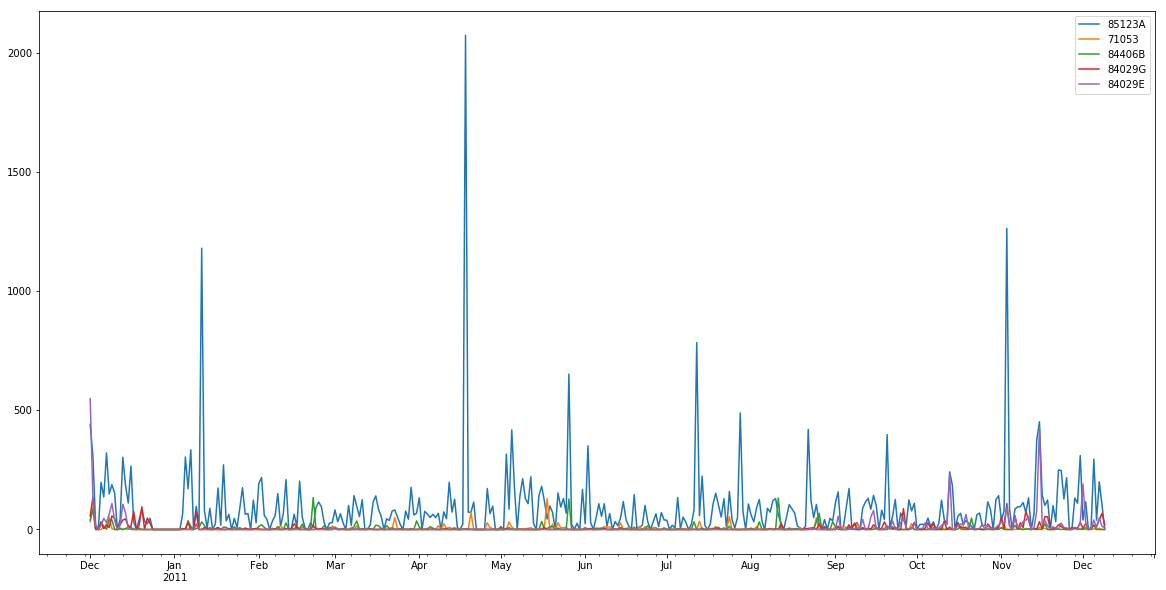

In [29]:
#Charting first 5 products from dataset
df_for_ts.iloc[:,0:5].plot(figsize=(20,10))
plt.legend()
plt.show()

#### Converting timeseries data to Amazon SageMaker - JSON format

Amazon SageMaker needs training and test data in specific JSON format. Lets convert TimeSeries Dataframe to JSON format that SageMaker needs

In [31]:
#Define various values which SageMaker use. All these are not used here but kept for understanding.
freq = 'D'
prediction_length = 14 #Two weeks 
context_length = 60 #Two months
t0 = '2010-12-01 00:00:00' #Start date of our dataframe
data_length = 374
num_ts = 3651

In [32]:
#Pandas TimeSeries to JSON Utility functions from Amazone Example Notebook. 
encoding = "utf-8"
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat)).encode(encoding)

#### Write timeseries data to train and test json files
This is just trial to ensure that it is working. Same logic is being used in SageMaker jupyter notebook to comvert csv to json. After checking saved filed it is verified that it is working as expected.

In [33]:
#Write timeseries data to train and test json files

#Remove from train data last entries equal to prediction_length. This is hold out data.
trainseries = df_for_ts.apply(lambda x: series_to_jsonline(x[:-prediction_length]))
#In test data no need to remove last entries
testseries = df_for_ts.apply(series_to_jsonline)

with open('train.json', 'wb') as ftrain, open('test.json', 'wb') as ftest:
    for v in trainseries:
        ftrain.write(v)
        ftrain.write('\n'.encode(encoding))
    for v in testseries:
        ftest.write(v)
        ftest.write('\n'.encode(encoding))
            

##### Use timeseries.csv file saved earlier to train and test DeepAR model in SageMaker for forecasting. SageMaker notebook 'Digicast.ipynb' reads data from this file

## Product category indentification

In [34]:
import spacy

In [ ]:
#Download spacy depedency which contains "English tokenizer, tagger, parser, NER and word vectors"
#!python -m spacy download en_core_web_md

In [36]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_md')

##### There are 2 broad product categories indentified by looking at data

1. Stationery & Gifts
2. Home & Decor

In [37]:
categories = [u"Stationery & Gifts", u"Home & Decor"]
categories_lower = []
for c in categories:
    categories_lower.append(c.lower())

#### Define utility function to find product category from it's description

In [38]:
# A very simple classification based on nlp token similarity


def find_product_category(product_description):
    maxvalue = 0
    i=0
    cindex=0
    docP = nlp(product_description.lower())
    
    for c in categories_lower:
        docC = nlp(c)
        
        tmaxvalue = 0
        for t in docP:
            similarity = t.similarity(docC)
            if similarity > tmaxvalue:
                tmaxvalue = similarity
                
        if tmaxvalue > maxvalue:
            maxvalue = tmaxvalue
            cindex = i
        i+=1
    return(cindex)

#Specifying otypes is must to avoid np.vecrorize calling first row twice for determining output datatype       
vect_find_product_category = np.vectorize(find_product_category, otypes=[int])

def get_category_name(catcode):
    return categories[catcode]

#Specifying otypes is must to avoid np.vecrorize calling first row twice for determining output datatype       
vect_get_category_name = np.vectorize(get_category_name, otypes=[str])

In [39]:
#Lets test it
description = u"MEASURING TAPE BABUSHKA RED"
catindex = find_product_category(description)   
print(description, ' - ' ,categories[catindex])

MEASURING TAPE BABUSHKA RED  -  Stationery & Gifts


In [40]:
df_cleaned.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [41]:
#Get uniques rows of stockcodes for classifying them to one of the categories
df_stockcode_unique = pd.DataFrame(df_cleaned.groupby(['StockCode','Description'])['Quantity'].sum()) 
df_stockcode_unique.reset_index(inplace=True)

#Remove rows of 'Bank Charges', 'DOTCOM POSTAGE', 'POSTAGE' etc which is not relevent for product categorization
df_stockcode_unique = df_stockcode_unique[~df_stockcode_unique['StockCode'].isin(['BANK CHARGES','C2','DOT','M','PADS','POST'])]
df_stockcode_unique.head()

StockCode                  Description  Quantity
0     10002  INFLATABLE POLITICAL GLOBE        823
1     10080     GROOVY CACTUS INFLATABLE       291
2     10120                 DOGGY RUBBER       192
3    10123C        HEARTS WRAPPING TAPE          5
4    10124A  SPOTS ON RED BOOKCOVER TAPE        16

In [42]:
df_stockcode_unique['Catcode'] = 0
df_stockcode_unique['Category'] = ''
df_stockcode_unique.head()

StockCode                  Description  Quantity  Catcode Category
0     10002  INFLATABLE POLITICAL GLOBE        823        0         
1     10080     GROOVY CACTUS INFLATABLE       291        0         
2     10120                 DOGGY RUBBER       192        0         
3    10123C        HEARTS WRAPPING TAPE          5        0         
4    10124A  SPOTS ON RED BOOKCOVER TAPE        16        0

#### Classify products to one of the category from it's description

In [43]:
#This operation will take time due to number of rows
df_stockcode_unique['Catcode'] = vect_find_product_category(df_stockcode_unique['Description'])
df_stockcode_unique.head()

StockCode                  Description  Quantity  Catcode Category
0     10002  INFLATABLE POLITICAL GLOBE        823        0         
1     10080     GROOVY CACTUS INFLATABLE       291        1         
2     10120                 DOGGY RUBBER       192        1         
3    10123C        HEARTS WRAPPING TAPE          5        0         
4    10124A  SPOTS ON RED BOOKCOVER TAPE        16        1

In [44]:
df_stockcode_unique['Category'] = vect_get_category_name(df_stockcode_unique['Catcode'])
df_stockcode_unique.head()

StockCode                  Description  Quantity  Catcode  \
0     10002  INFLATABLE POLITICAL GLOBE        823        0   
1     10080     GROOVY CACTUS INFLATABLE       291        1   
2     10120                 DOGGY RUBBER       192        1   
3    10123C        HEARTS WRAPPING TAPE          5        0   
4    10124A  SPOTS ON RED BOOKCOVER TAPE        16        1   

             Category  
0  Stationery & Gifts  
1        Home & Decor  
2        Home & Decor  
3  Stationery & Gifts  
4        Home & Decor

In [45]:
#Save it for later use.
df_stockcode_unique.to_csv('product_categories.csv', index=0)

#Later above saved csv can be loaded to start executing notebook from here
#df_stockcode_unique = pd.read_csv('product_categories.csv')
#df_stockcode_unique.head()

#### Barchart Top 5 products

In [46]:
#Get Top 5 products
df_chartdata = df_stockcode_unique.sort_values(['Quantity'], ascending=[False]).head(5)
display(df_chartdata)

StockCode                         Description  Quantity  Catcode  \
3013     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119        0   
3436    85099B             JUMBO BAG RED RETROSPOT     45088        0   
3270     84879       ASSORTED COLOUR BIRD ORNAMENT     35217        0   
3451    85123A  WHITE HANGING HEART T-LIGHT HOLDER     34133        1   
431      21212     PACK OF 72 RETROSPOT CAKE CASES     33431        0   

                Category  
3013  Stationery & Gifts  
3436  Stationery & Gifts  
3270  Stationery & Gifts  
3451        Home & Decor  
431   Stationery & Gifts

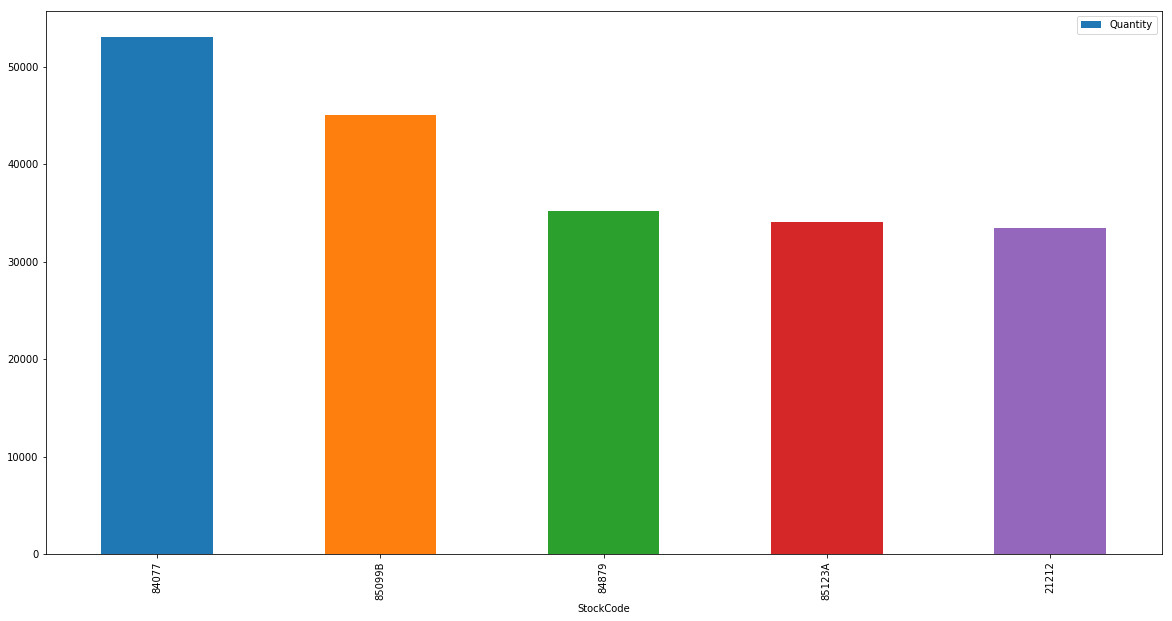

In [47]:
df_chartdata.plot.bar(x='StockCode',y='Quantity',figsize=(20,10))

In [48]:
#We need to merge Catcode and Category in cleaned dataset
#Prepare for merging. Set StockCode as index for both dataframes
df_cleaned.set_index('StockCode', inplace=True)
df_stockcode_unique.set_index('StockCode', inplace=True)
display(df_cleaned.head())
display(df_stockcode_unique.head())

InvoiceNo                          Description  Quantity  \
StockCode                                                            
85123A       536365   WHITE HANGING HEART T-LIGHT HOLDER         6   
71053        536365                  WHITE METAL LANTERN         6   
84406B       536365       CREAM CUPID HEARTS COAT HANGER         8   
84029G       536365  KNITTED UNION FLAG HOT WATER BOTTLE         6   
84029E       536365       RED WOOLLY HOTTIE WHITE HEART.         6   

                  InvoiceDate  UnitPrice CustomerID         Country  
StockCode                                                            
85123A    2010-12-01 08:26:00       2.55      17850  United Kingdom  
71053     2010-12-01 08:26:00       3.39      17850  United Kingdom  
84406B    2010-12-01 08:26:00       2.75      17850  United Kingdom  
84029G    2010-12-01 08:26:00       3.39      17850  United Kingdom  
84029E    2010-12-01 08:26:00       3.39      17850  United Kingdom

Description  Quantity  Catcode            Category
StockCode                                                                    
10002      INFLATABLE POLITICAL GLOBE        823        0  Stationery & Gifts
10080         GROOVY CACTUS INFLATABLE       291        1        Home & Decor
10120                     DOGGY RUBBER       192        1        Home & Decor
10123C           HEARTS WRAPPING TAPE          5        0  Stationery & Gifts
10124A     SPOTS ON RED BOOKCOVER TAPE        16        1        Home & Decor

In [49]:
#Remove other unwanted columns which we are not merging.
df_stockcode_unique.drop(columns=['Description','Quantity'], inplace=True)
display(df_stockcode_unique.head())

Catcode            Category
StockCode                             
10002            0  Stationery & Gifts
10080            1        Home & Decor
10120            1        Home & Decor
10123C           0  Stationery & Gifts
10124A           1        Home & Decor

In [50]:
#Lets merge df_cleaned and df_stockcode_unique to add product code and product category to df_cleaned dataset
df_cleaned = df_cleaned.merge(df_stockcode_unique, how='left', left_index=True, right_index=True)
display(df_cleaned.head())

InvoiceNo                  Description  Quantity  \
StockCode                                                    
10002        536370  INFLATABLE POLITICAL GLOBE         48   
10002        536382  INFLATABLE POLITICAL GLOBE         12   
10002        536863  INFLATABLE POLITICAL GLOBE          1   
10002        537047  INFLATABLE POLITICAL GLOBE          1   
10002        537227  INFLATABLE POLITICAL GLOBE         24   

                  InvoiceDate  UnitPrice CustomerID         Country  Catcode  \
StockCode                                                                      
10002     2010-12-01 08:45:00       0.85      12583          France      0.0   
10002     2010-12-01 09:45:00       0.85      16098  United Kingdom      0.0   
10002     2010-12-03 11:19:00       0.85      17967  United Kingdom      0.0   
10002     2010-12-05 11:02:00       0.85      13069  United Kingdom      0.0   
10002     2010-12-06 08:42:00       0.85      17677  United Kingdom      0.0   

                     Category  
StockCode                      
10002      Stationery & Gifts  
10002      Stationery & Gifts  
10002      Stationery & Gifts  
10002      Stationery & Gifts  
10002      Stationery & Gifts

In [51]:
#Reset index 
df_cleaned.reset_index(['StockCode'],inplace=True)
display(df_cleaned.head())

StockCode InvoiceNo                  Description  Quantity  \
0     10002    536370  INFLATABLE POLITICAL GLOBE         48   
1     10002    536382  INFLATABLE POLITICAL GLOBE         12   
2     10002    536863  INFLATABLE POLITICAL GLOBE          1   
3     10002    537047  INFLATABLE POLITICAL GLOBE          1   
4     10002    537227  INFLATABLE POLITICAL GLOBE         24   

          InvoiceDate  UnitPrice CustomerID         Country  Catcode  \
0 2010-12-01 08:45:00       0.85      12583          France      0.0   
1 2010-12-01 09:45:00       0.85      16098  United Kingdom      0.0   
2 2010-12-03 11:19:00       0.85      17967  United Kingdom      0.0   
3 2010-12-05 11:02:00       0.85      13069  United Kingdom      0.0   
4 2010-12-06 08:42:00       0.85      17677  United Kingdom      0.0   

             Category  
0  Stationery & Gifts  
1  Stationery & Gifts  
2  Stationery & Gifts  
3  Stationery & Gifts  
4  Stationery & Gifts

## Find customer clusters based on buying behaviours

#### Basket size check

In [12]:
#If we have to execute notebook from here then it is possible to load already cleaned data from csv, 
# which was saved earlier.
#df_cleaned = pd.read_csv('cleaned.csv', index_col=0)
#Convert InvoiceDate to Datetime
#df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [52]:
df_cleaned.head()

StockCode InvoiceNo                  Description  Quantity  \
0     10002    536370  INFLATABLE POLITICAL GLOBE         48   
1     10002    536382  INFLATABLE POLITICAL GLOBE         12   
2     10002    536863  INFLATABLE POLITICAL GLOBE          1   
3     10002    537047  INFLATABLE POLITICAL GLOBE          1   
4     10002    537227  INFLATABLE POLITICAL GLOBE         24   

          InvoiceDate  UnitPrice CustomerID         Country  Catcode  \
0 2010-12-01 08:45:00       0.85      12583          France      0.0   
1 2010-12-01 09:45:00       0.85      16098  United Kingdom      0.0   
2 2010-12-03 11:19:00       0.85      17967  United Kingdom      0.0   
3 2010-12-05 11:02:00       0.85      13069  United Kingdom      0.0   
4 2010-12-06 08:42:00       0.85      17677  United Kingdom      0.0   

             Category  
0  Stationery & Gifts  
1  Stationery & Gifts  
2  Stationery & Gifts  
3  Stationery & Gifts  
4  Stationery & Gifts

In [53]:
#Calculate Total Price of a transaction
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity']
df_cleaned.head()

StockCode InvoiceNo                  Description  Quantity  \
0     10002    536370  INFLATABLE POLITICAL GLOBE         48   
1     10002    536382  INFLATABLE POLITICAL GLOBE         12   
2     10002    536863  INFLATABLE POLITICAL GLOBE          1   
3     10002    537047  INFLATABLE POLITICAL GLOBE          1   
4     10002    537227  INFLATABLE POLITICAL GLOBE         24   

          InvoiceDate  UnitPrice CustomerID         Country  Catcode  \
0 2010-12-01 08:45:00       0.85      12583          France      0.0   
1 2010-12-01 09:45:00       0.85      16098  United Kingdom      0.0   
2 2010-12-03 11:19:00       0.85      17967  United Kingdom      0.0   
3 2010-12-05 11:02:00       0.85      13069  United Kingdom      0.0   
4 2010-12-06 08:42:00       0.85      17677  United Kingdom      0.0   

             Category  TotalPrice  
0  Stationery & Gifts       40.80  
1  Stationery & Gifts       10.20  
2  Stationery & Gifts        0.85  
3  Stationery & Gifts        0.85  
4  Stationery & Gifts       20.40

In [74]:
#Create various aggregates for each customer of StockCode, Quantity and Price
df_customer = (df_cleaned.groupby(by=['CustomerID'], as_index=False)
       .agg({'InvoiceDate':['min','max'],'InvoiceNo':'count', 'StockCode':'count', 'Quantity':['min','max','mean','sum'], 
             'UnitPrice':['min','max','mean','sum'], 'TotalPrice':['min','max','mean','sum']}))

#Rename column names by merging original name with new second level name created by aggregate function 
df_customer.columns = [col[0] if col[1] == '' else '_'.join(col).strip() for col in df_customer.columns.values]

df_customer.head()

CustomerID     InvoiceDate_min     InvoiceDate_max  InvoiceNo_count  \
0      12347 2010-12-07 14:57:00 2011-12-07 15:52:00              189   
1      12348 2010-12-16 19:09:00 2011-09-25 13:13:00               33   
2      12349 2011-11-21 09:51:00 2011-11-21 09:51:00               85   
3      12350 2011-02-02 16:01:00 2011-02-02 16:01:00               17   
4      12352 2011-02-16 12:33:00 2011-11-03 14:37:00               80   

   StockCode_count  Quantity_min  Quantity_max  Quantity_mean  Quantity_sum  \
0              189             2           240      13.375661          2528   
1               33             1           144      75.303030          2485   
2               85             1            36       8.788235           747   
3               17             1            24      11.588235           197   
4               80             1            16       6.100000           488   

   UnitPrice_min  UnitPrice_max  UnitPrice_mean  UnitPrice_sum  \
0           0.25          12.75        2.637090         498.41   
1           0.29          40.00        5.444848         179.68   
2           0.42         300.00        7.821647         664.84   
3           0.85          40.00        3.841176          65.30   
4           0.65         376.50       16.795250        1343.62   

   TotalPrice_min  TotalPrice_max  TotalPrice_mean  TotalPrice_sum  
0            5.04           249.6        23.556720         4452.22  
1           13.20           240.0        56.389091         1860.84  
2            6.64           300.0        24.032588         2042.77  
3            8.50            40.0        19.670588          334.40  
4            9.90           376.5        30.194500         2415.56

In [75]:
#Find last invoicing date. In real scenarios, this should be today's date
last_date = df_customer['InvoiceDate_max'].max()

#Create aging values of the first and last transaction of each customer
df_customer['Aging_min'] = (last_date - df_customer.InvoiceDate_min).dt.days
df_customer['Aging_max'] = (last_date - df_customer.InvoiceDate_max).dt.days

df_customer.head()

CustomerID     InvoiceDate_min     InvoiceDate_max  InvoiceNo_count  \
0      12347 2010-12-07 14:57:00 2011-12-07 15:52:00              189   
1      12348 2010-12-16 19:09:00 2011-09-25 13:13:00               33   
2      12349 2011-11-21 09:51:00 2011-11-21 09:51:00               85   
3      12350 2011-02-02 16:01:00 2011-02-02 16:01:00               17   
4      12352 2011-02-16 12:33:00 2011-11-03 14:37:00               80   

   StockCode_count  Quantity_min  Quantity_max  Quantity_mean  Quantity_sum  \
0              189             2           240      13.375661          2528   
1               33             1           144      75.303030          2485   
2               85             1            36       8.788235           747   
3               17             1            24      11.588235           197   
4               80             1            16       6.100000           488   

   UnitPrice_min  UnitPrice_max  UnitPrice_mean  UnitPrice_sum  \
0           0.25          12.75        2.637090         498.41   
1           0.29          40.00        5.444848         179.68   
2           0.42         300.00        7.821647         664.84   
3           0.85          40.00        3.841176          65.30   
4           0.65         376.50       16.795250        1343.62   

   TotalPrice_min  TotalPrice_max  TotalPrice_mean  TotalPrice_sum  Aging_min  \
0            5.04           249.6        23.556720         4452.22        366   
1           13.20           240.0        56.389091         1860.84        357   
2            6.64           300.0        24.032588         2042.77         18   
3            8.50            40.0        19.670588          334.40        309   
4            9.90           376.5        30.194500         2415.56        296   

   Aging_max  
0          1  
1         74  
2         18  
3        309  
4         35

In [76]:
list_cols = ['InvoiceNo_count', 'StockCode_count', 'Quantity_min', 'Quantity_max', 'Quantity_mean',
        'UnitPrice_min', 'UnitPrice_max', 'UnitPrice_mean',  
        'TotalPrice_min', 'TotalPrice_max', 'TotalPrice_mean', 'Aging_min', 'Aging_max']


selected_data = df_customer.copy(deep = True)
matrix = selected_data[list_cols].values

In [77]:
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

In [78]:
# This code is adapted from : 
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette_score_test(X, range_n_clusters):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9406087526659721
For n_clusters = 3 The average silhouette_score is : 0.931583675790632
For n_clusters = 4 The average silhouette_score is : 0.8662303059267281
For n_clusters = 5 The average silhouette_score is : 0.2989579564869748
For n_clusters = 6 The average silhouette_score is : 0.3374632611502605
For n_clusters = 7 The average silhouette_score is : 0.407506295027523
For n_clusters = 8 The average silhouette_score is : 0.41052260796443546
For n_clusters = 9 The average silhouette_score is : 0.41509600572561317
For n_clusters = 10 The average silhouette_score is : 0.42440796378070134
For n_clusters = 11 The average silhouette_score is : 0.42453900534334466
For n_clusters = 12 The average silhouette_score is : 0.42995589500523124
For n_clusters = 13 The average silhouette_score is : 0.43661047599248015
For n_clusters = 14 The average silhouette_score is : 0.41007620491820657


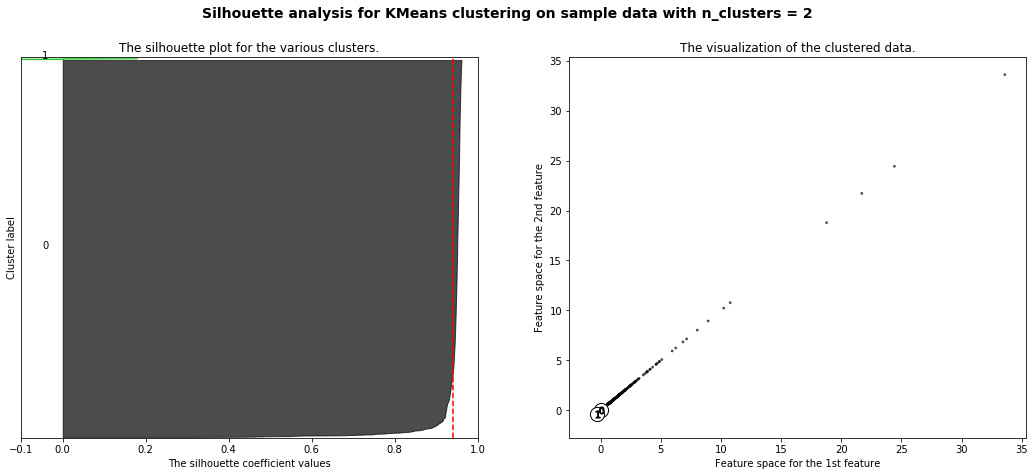

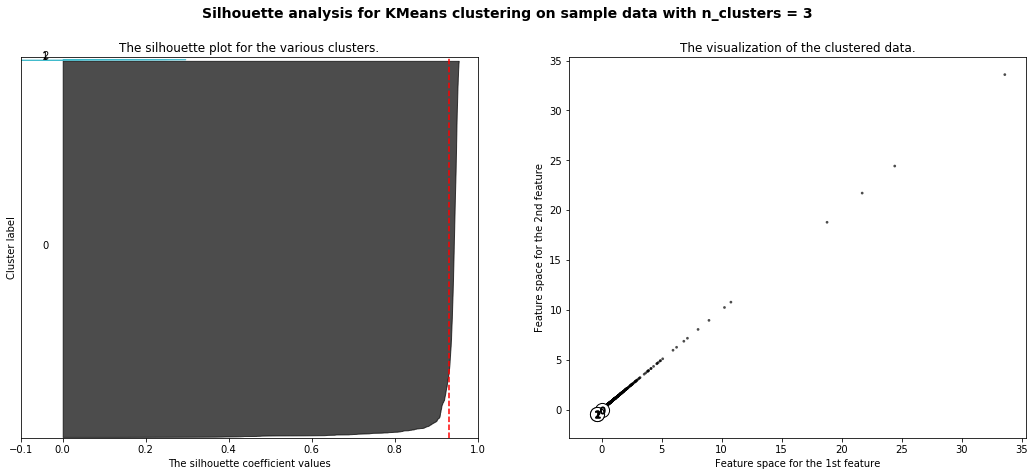

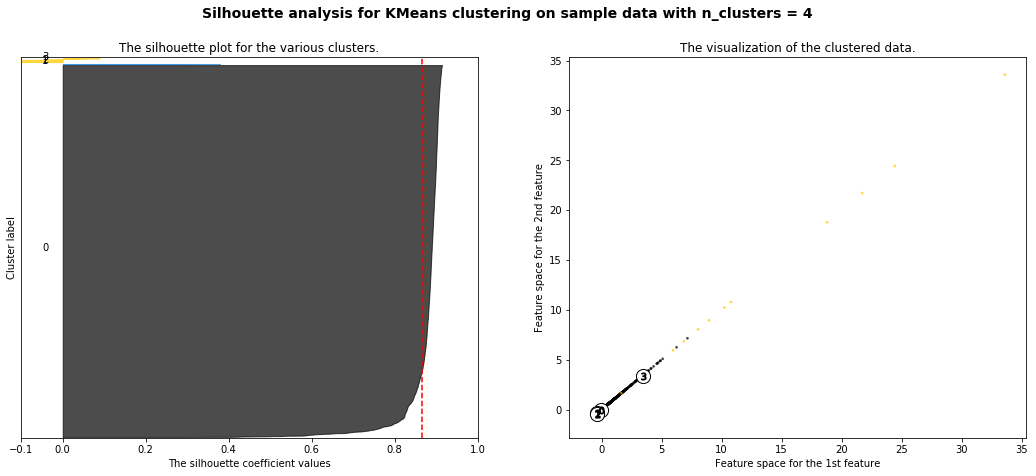

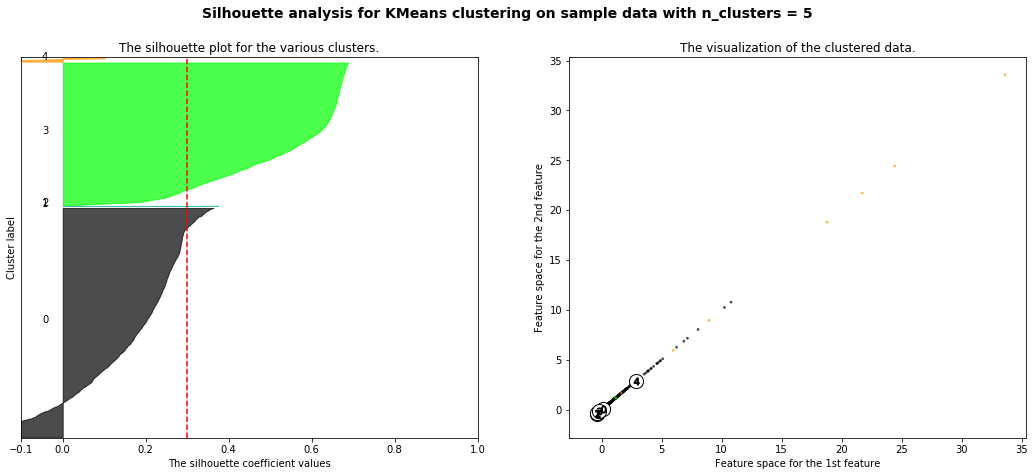

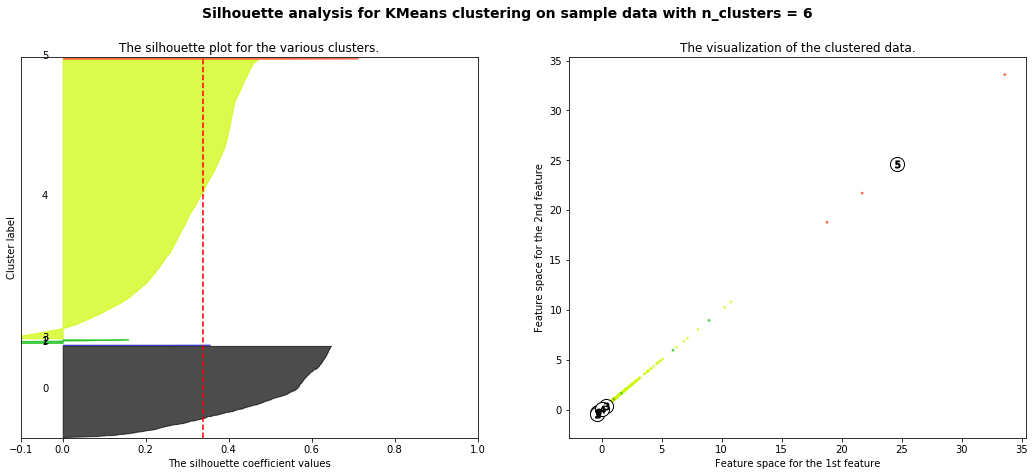

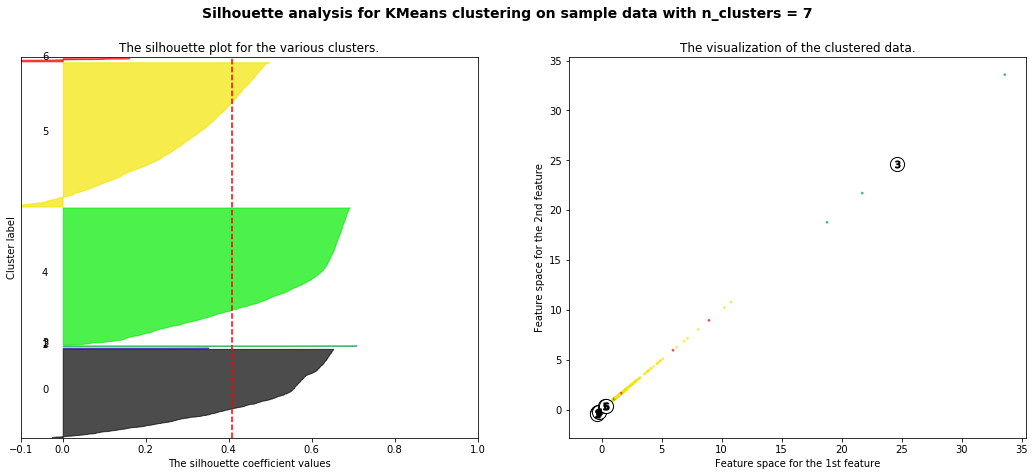

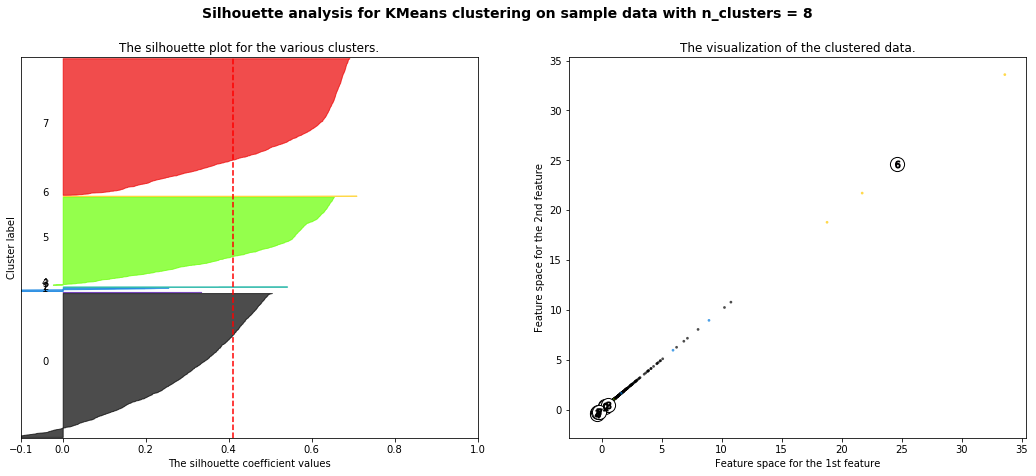

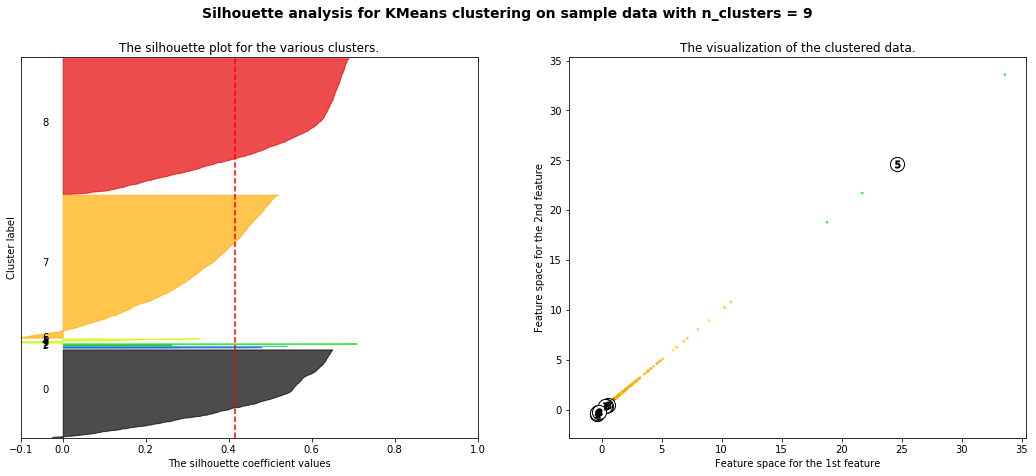

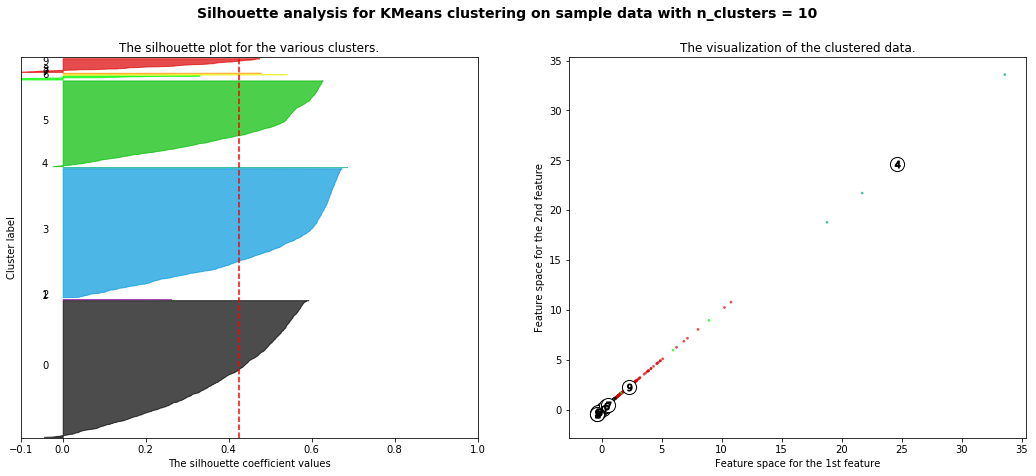

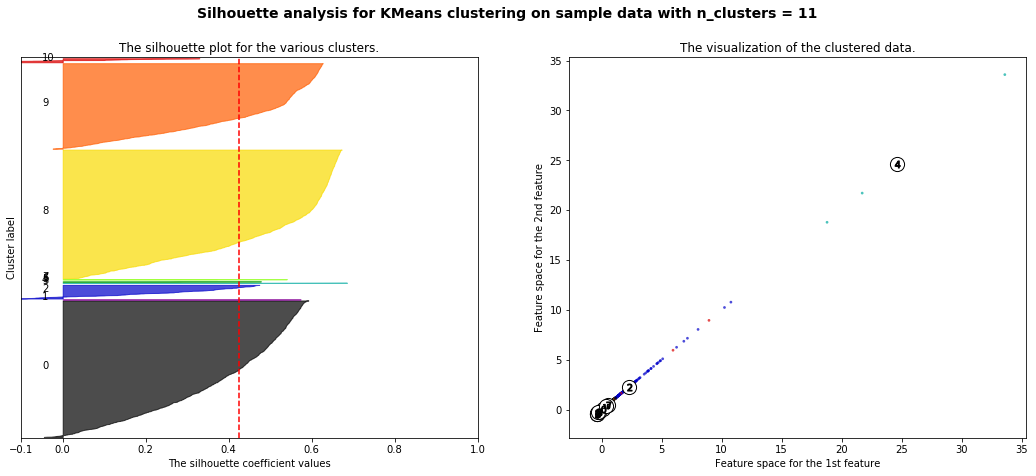

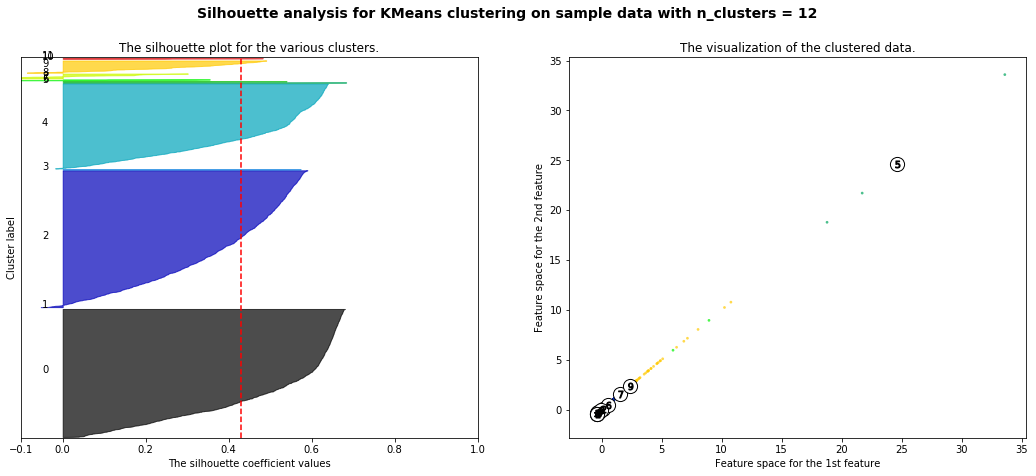

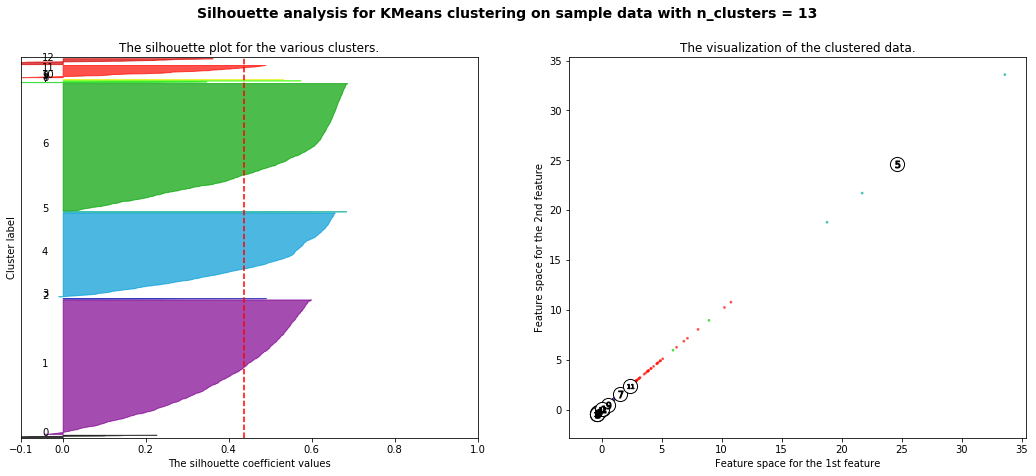

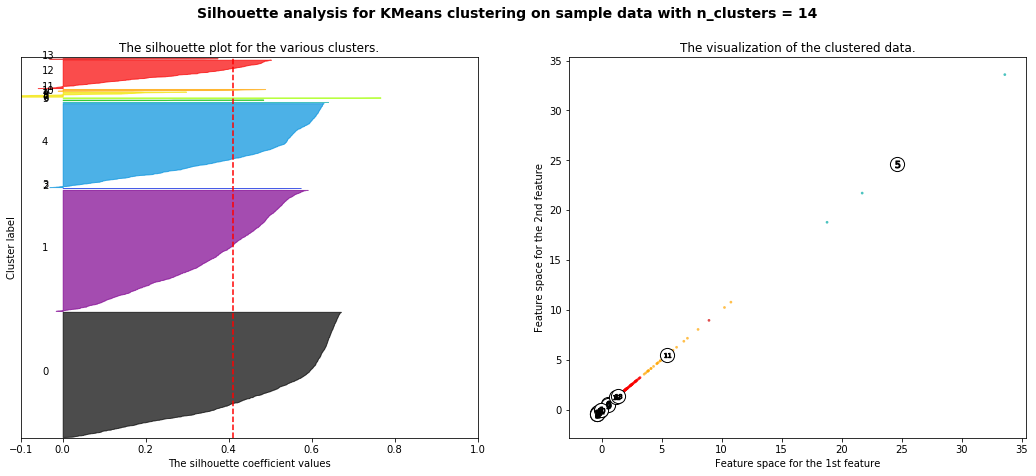

In [79]:
silhouette_score_test(scaled_matrix, range(2,15))

#### Looking at silhouette_score, 6 clusters looks reasonable number because below 6 there is single big cluster and above 6 there is formation of smaller ones there by getting false better score.

In [80]:
#Lets create 6 customer clusters with
n_clusters = 6

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)


In [81]:
#Print number of customer in each cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['No of clients']).T

1     0   3  5  4  2
No of clients  3224  1053  42  4  3  1

From numbers above, we can see that clusters are not equally distributed


In [82]:
#Attach Cluster to each customer line 
selected_data.loc[:, 'cluster'] = clusters_clients
selected_data.head()

CustomerID     InvoiceDate_min     InvoiceDate_max  InvoiceNo_count  \
0      12347 2010-12-07 14:57:00 2011-12-07 15:52:00              189   
1      12348 2010-12-16 19:09:00 2011-09-25 13:13:00               33   
2      12349 2011-11-21 09:51:00 2011-11-21 09:51:00               85   
3      12350 2011-02-02 16:01:00 2011-02-02 16:01:00               17   
4      12352 2011-02-16 12:33:00 2011-11-03 14:37:00               80   

   StockCode_count  Quantity_min  Quantity_max  Quantity_mean  Quantity_sum  \
0              189             2           240      13.375661          2528   
1               33             1           144      75.303030          2485   
2               85             1            36       8.788235           747   
3               17             1            24      11.588235           197   
4               80             1            16       6.100000           488   

   UnitPrice_min  UnitPrice_max  UnitPrice_mean  UnitPrice_sum  \
0           0.25          12.75        2.637090         498.41   
1           0.29          40.00        5.444848         179.68   
2           0.42         300.00        7.821647         664.84   
3           0.85          40.00        3.841176          65.30   
4           0.65         376.50       16.795250        1343.62   

   TotalPrice_min  TotalPrice_max  TotalPrice_mean  TotalPrice_sum  Aging_min  \
0            5.04           249.6        23.556720         4452.22        366   
1           13.20           240.0        56.389091         1860.84        357   
2            6.64           300.0        24.032588         2042.77         18   
3            8.50            40.0        19.670588          334.40        309   
4            9.90           376.5        30.194500         2415.56        296   

   Aging_max  cluster  
0          1        1  
1         74        1  
2         18        1  
3        309        0  
4         35        1

### Customer types from clusters and associted buying information
Looking at data and cluster from above table, we can see that:
- One of the large clusters is of buyers who made sizable purchase but are not buying from long time
- Another large cluster is of repeat customers

This information tells us, which customers should be followed up to convert them in repeated customers and which customers we should treat as loyal customers

We have more repeat customers than one time buyers. 

In [83]:
#Save Customer Cluster information
selected_data.to_csv('customer_clusters.csv', index=0)
#selected_data.to_json('customer_clusters.json')

#Load from saved file from second run onward because K-Means gives different 
#numbers to cluster every time and it messes with pre-saved Keras model
#selected_data.read_csv('customer_clusters.csv')

#### Create Model to predict new customer's cluster based on his first single Invoice information

In [84]:
#Select columns which are related to only single Invoice because we have to classify customer based on his first Invoice
pred_cols = ['StockCode_count', 'Quantity_min', 'Quantity_max', 'Quantity_mean', 'UnitPrice_min',
            'UnitPrice_max','UnitPrice_mean']

X = selected_data[pred_cols]
Y = selected_data['cluster']

#split the data in train and test sets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.2, random_state=210)

In [85]:
#Convert Y data from int to one hot encoding  
Y_train_one_hot = keras.utils.to_categorical(Y_train.values, num_classes=n_clusters)
Y_test_one_hot = keras.utils.to_categorical(Y_test.values, num_classes=n_clusters)

#### Using Keras to create Multilayer Perceptron (MLP) for multi-class softmax classification

In [90]:
#Create keras model
model = Sequential()
model.add(Dense(24, activation='relu', input_dim=len(pred_cols)))
model.add(Dense(21, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(n_clusters, activation='softmax'))

optimizer = Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [91]:
checkpointer = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None)
model.fit(X_train.values, Y_train_one_hot, epochs=20, batch_size=24,callbacks=[checkpointer])

Epoch 1/20
3461/3461 [==============================] - 1s 251us/step - loss: 1.6380 - acc: 0.5579
Epoch 2/20
3461/3461 [==============================] - 0s 63us/step - loss: 0.6796 - acc: 0.7428
Epoch 3/20
3461/3461 [==============================] - 0s 63us/step - loss: 0.6740 - acc: 0.7431
Epoch 4/20
3461/3461 [==============================] - 0s 64us/step - loss: 0.6638 - acc: 0.7480
Epoch 5/20
3461/3461 [==============================] - 0s 63us/step - loss: 0.6641 - acc: 0.7509
Epoch 6/20
3461/3461 [==============================] - 0s 65us/step - loss: 0.6599 - acc: 0.7585
Epoch 7/20
3461/3461 [==============================] - 0s 68us/step - loss: 0.6617 - acc: 0.7561
Epoch 00007: early stopping


In [92]:
#Check score of a model
loss, acc = model.evaluate(X_test.values, Y_test_one_hot, batch_size=32)
print('Score-> loss: {}, acc: {}'.format(loss,acc))

866/866 [==============================] - 0s 121us/step
Score-> loss: 0.6369087847323947, acc: 0.745958429561201


In [93]:
#Save model for future use
model.save('keras_model.h5')
#model = keras.models.load_model('keras_model.h5')

In [94]:
def predict_cust_cluster(data):
    data = data[pred_cols]
    predictions = model.predict_classes(data.values)
    return predictions

In [95]:
#Check prediction against actual
prediction = predict_cust_cluster(X_test[:10])
print(prediction)
print(Y_test[:10].values)

[1 1 1 1 1 1 1 1 1 1]
[1 0 1 0 0 1 1 0 0 1]


### Confusion matrix

Source code of plotting confusion matrix is adapted from <a href='http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py'>scikit-learn</a>

In [96]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm, '\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 39 167   0   0]
 [ 44 607   0   0]
 [  2   5   0   0]
 [  2   0   0   0]] 


Normalized confusion matrix
[[0.19 0.81 0.   0.  ]
 [0.07 0.93 0.   0.  ]
 [0.29 0.71 0.   0.  ]
 [1.   0.   0.   0.  ]] 




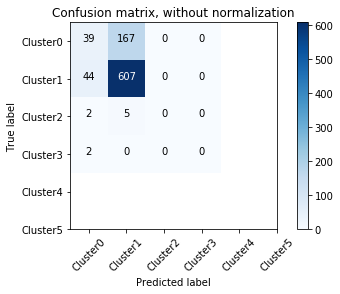

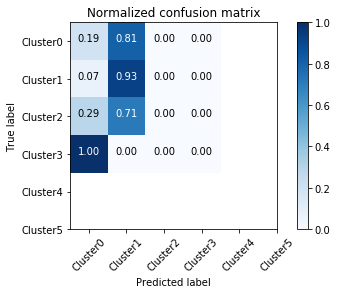

In [97]:
#Predict Test data
Y_pred = predict_cust_cluster(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test.values, Y_pred)
np.set_printoptions(precision=2)

#Give labels to clusters
class_names = ['Cluster0','Cluster1','Cluster2','Cluster3','Cluster4','Cluster5']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Find top 5 customers in each cluster based on their purchase value

In [98]:
top5_cluster0 = (selected_data[selected_data['cluster'] == 0]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)
top5_cluster1 = (selected_data[selected_data['cluster'] == 1]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)
top5_cluster2 = (selected_data[selected_data['cluster'] == 2]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)
top5_cluster3 = (selected_data[selected_data['cluster'] == 3]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)
top5_cluster4 = (selected_data[selected_data['cluster'] == 4]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)
top5_cluster5 = (selected_data[selected_data['cluster'] == 5]).sort_values(
                                            ['TotalPrice_sum'], ascending=[False]).head(5)

In [99]:
top5_cluster0

CustomerID     InvoiceDate_min     InvoiceDate_max  InvoiceNo_count  \
193       12590 2011-05-12 14:46:00 2011-05-12 14:52:00               77   
562       13093 2010-12-01 15:00:00 2011-03-09 12:14:00              176   
481       12980 2010-12-16 11:36:00 2011-07-05 09:34:00               24   
4006      17850 2010-12-01 08:26:00 2010-12-02 15:27:00              361   
3075      16553 2010-12-14 13:58:00 2011-06-29 15:42:00               90   

      StockCode_count  Quantity_min  Quantity_max  Quantity_mean  \
193                77             1           600      63.571429   
562               176             3           108      25.272727   
481                24             6           144      47.958333   
4006              361             2            12       5.814404   
3075               90             2           288      53.266667   

      Quantity_sum  UnitPrice_min  UnitPrice_max  UnitPrice_mean  \
193           4895           0.65         523.00        9.637143   
562           4448           0.21          14.95        3.156648   
481           1151           2.10          34.95       13.818750   
4006          2099           1.06          35.75        3.888670   
3075          4794           0.21          12.75        2.167333   

      UnitPrice_sum  TotalPrice_min  TotalPrice_max  TotalPrice_mean  \
193          742.06           39.60          523.00       147.080260   
562          555.57            5.04          272.00        50.024886   
481          331.65           91.80          838.80       336.041250   
4006        1403.81            5.30          107.25        18.250748   
3075         195.06           11.70          244.80        70.821333   

      TotalPrice_sum  Aging_min  Aging_max  cluster  
193         11325.18        210        210        0  
562          8804.38        372        275        0  
481          8064.99        358        157        0  
4006         6588.52        373        371        0  
3075         6373.92        359        162        0

In [100]:
#Save to csv
top5_cluster0.to_csv('top5_cluster0.csv')
top5_cluster1.to_csv('top5_cluster1.csv')
top5_cluster2.to_csv('top5_cluster2.csv')
top5_cluster3.to_csv('top5_cluster3.csv')
top5_cluster4.to_csv('top5_cluster4.csv')
top5_cluster5.to_csv('top5_cluster5.csv')
#Save to json
top5_cluster0.to_json('top5_cluster0.json')
top5_cluster1.to_json('top5_cluster1.json')
top5_cluster2.to_json('top5_cluster2.json')
top5_cluster3.to_json('top5_cluster3.json')
top5_cluster4.to_json('top5_cluster4.json')
top5_cluster5.to_json('top5_cluster5.json')

#### Find top 5 products that are top5 customers in each cluster are buying

In [101]:
#Find top 5 products that are top5 customers in each cluster are buying
top5_products_in_cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster0['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)
top5_products_in_cluster1 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster1['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)
top5_products_in_cluster2 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster2['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)
top5_products_in_cluster3 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster3['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)
top5_products_in_cluster4 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster4['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)
top5_products_in_cluster5 = df_cleaned[df_cleaned['CustomerID'].isin(top5_cluster5['CustomerID'])].sort_values(
                                            ['TotalPrice'], ascending=[False]).head(5)

In [102]:
top5_products_in_cluster5

StockCode InvoiceNo     Description  Quantity         InvoiceDate  \
431833         M    546329          Manual         1 2011-03-11 10:22:00   
431832         M    546328          Manual         1 2011-03-11 10:19:00   
431770       DOT    580727  DOTCOM POSTAGE         1 2011-12-05 17:17:00   
431769       DOT    579196  DOTCOM POSTAGE         1 2011-11-28 15:54:00   
431767       DOT    576339  DOTCOM POSTAGE         1 2011-11-14 15:27:00   

        UnitPrice CustomerID         Country  Catcode Category  TotalPrice  
431833    1687.17      14911            EIRE      NaN      NaN     1687.17  
431832    1687.17      14911            EIRE      NaN      NaN     1687.17  
431770    1599.26      14096  United Kingdom      NaN      NaN     1599.26  
431769    1526.76      14096  United Kingdom      NaN      NaN     1526.76  
431767    1500.36      14096  United Kingdom      NaN      NaN     1500.36

In [103]:
#Save to csv
top5_products_in_cluster0.to_csv('top5_products_in_cluster0.csv')
top5_products_in_cluster1.to_csv('top5_products_in_cluster1.csv')
top5_products_in_cluster2.to_csv('top5_products_in_cluster2.csv')
top5_products_in_cluster3.to_csv('top5_products_in_cluster3.csv')
top5_products_in_cluster4.to_csv('top5_products_in_cluster4.csv')
top5_products_in_cluster5.to_csv('top5_products_in_cluster5.csv')
#Save to json
top5_products_in_cluster0.to_json('top5_products_in_cluster0.json')
top5_products_in_cluster1.to_json('top5_products_in_cluster1.json')
top5_products_in_cluster2.to_json('top5_products_in_cluster2.json')
top5_products_in_cluster3.to_json('top5_products_in_cluster3.json')
top5_products_in_cluster4.to_json('top5_products_in_cluster4.json')
top5_products_in_cluster5.to_json('top5_products_in_cluster5.json')

### Conclusion
We are able to classify customers from their bucket information. It is surprising and interesting to see how much insight we can derive from a dataset which inititally had lot of junk. Cleaning was very important aspect for deriving a value from data.
This can be done even better if we have information of product categories available, which is more likely the case in real scenarios. If we can use product categories also in forming customer clusters then most likely we may get better separated clusters and prediction can work even better.
For SageMaker part, that is prediction of 2 weeks of demand based on historical data, please refer digicast.ipynb